# Simple Bayes Generative Model

Fit data to a gaussian model then sample from it.

* $P(Y|X)$ is the probability of being class Y given image X
* $P(X|Y)$ is the generative model which generate image X given Y.
  $$P(X|Y) = \frac{P(Y|X)\ P(X)}{P(Y)}$$

Given the training data, we can fit the data to a gaussian model to build $P(X|Y)$ and then sample from this gaussian model to generate some images. The following block is doing this task for MNIST dataset

Reading in and transforming data...


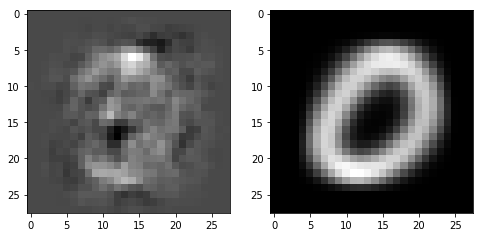

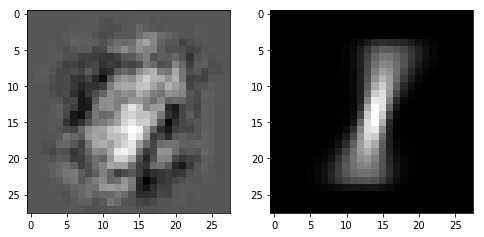

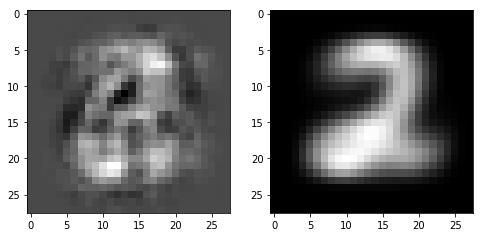

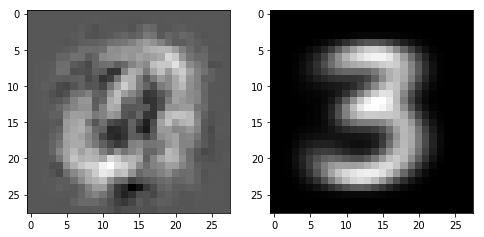

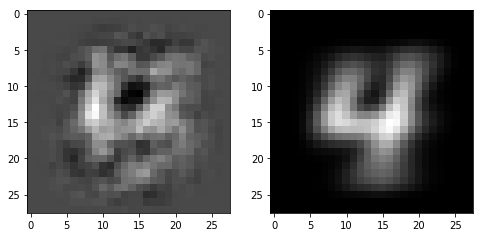

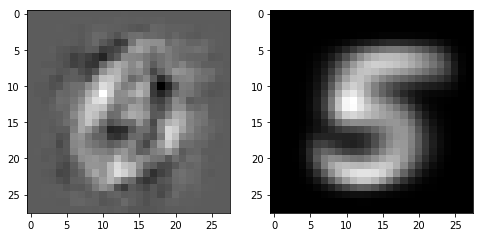

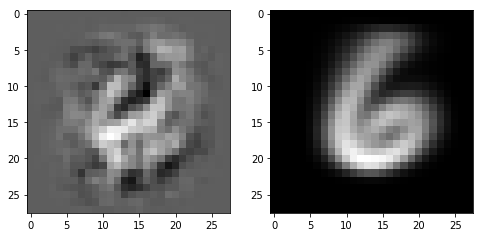

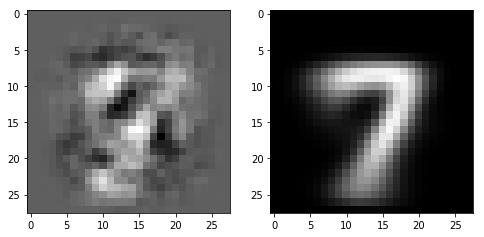

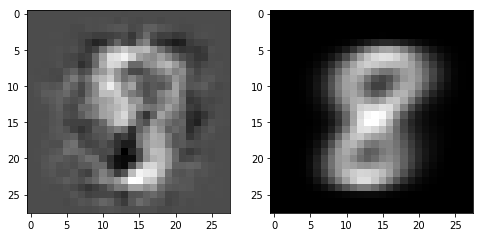

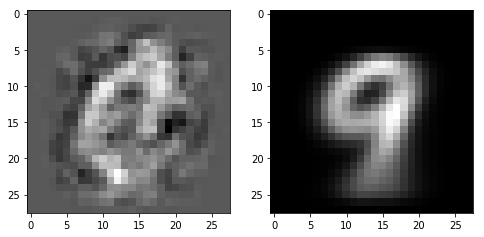

In [14]:
import util
import numpy as np
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt


class bayes_generator:
    def fit(self,x,y):
        self.n_cats = len(set(y))
        self.distributions = []
        for cat in range(self.n_cats):
            xK = x[y == cat]
            mean = np.mean(xK,axis = 0)
            cov = np.cov(x.T) # np.cov assumes each row is one variable (here pixel)
            gaussian_dis = {"m":mean, "c": cov}
            self.distributions.append(gaussian_dis)
    
    def sample_give_y(self,cat):
        dist = self.distributions[cat]
        return mvn.rvs(mean = dist["m"],cov=dist["c"])
    

X, Y = util.get_mnist()
gen = bayes_generator()
gen.fit(X,Y)
n_samples = 10
for k in range(n_samples):
    sample_generated = gen.sample_give_y(k).reshape(28,28)
    mean = gen.distributions[k]["m"].reshape(28, 28)
    plt.figure(figsize=(8,16))
    plt.subplot(121)
    plt.imshow(sample_generated,cmap='gray')
    plt.subplot(122)
    plt.imshow(mean,cmap='gray')
    plt.show()

# Using Multimodal Bayes

Without Multimodal, the model cannot for example model the translation and rotation inside image.

How to model it:
* Using [GMM](https://youtu.be/Rkl30Fr2S38) (Gaussian Mixture Model) from scikit learn
* GMM fit miltiple Gaussians with different weigths to the data
* GMM is latent variable model
* Laten variable $z$ represents which cluster $x$ blongs to
* i.e. 2 Clusters: $p(x) = p(z=1)p(x|z=1)+p(z=2)p(x|z=2)$
* $p(z)$ priority that any x belongs ot a cluster $z$
* $p(z)$ is categorical/discrete distribution (vector of numbers that sums to 1)
* $p(x|z)$ is single gaussian


how to assign the cluster:
* Use Bayes Rule!
* $P(z|x) = P(x|z)P(z)/P(x)$

* GMM is trained via expectation-maximization (EM)
* EM is iterative
* You need to choose number of clusters -> solution: VI-GMM

Graphical Model

GMM:
* y --------> z ---------> x
* sample $y\sim p(y)$ (class frequency)
* sample $z\sim p(z|y)$ (Wrting Style)
* sample $x\sim p(x|z,y)$ (image)

Reading in and transforming data...


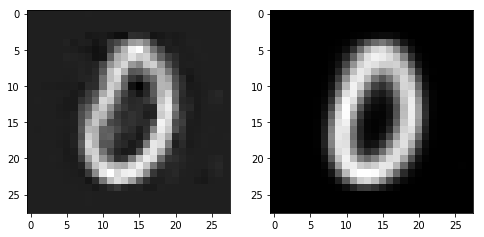

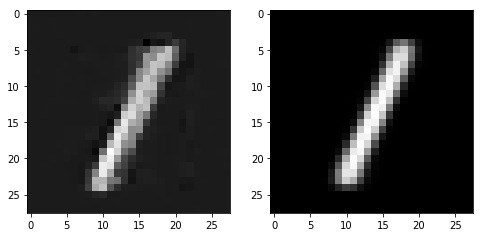

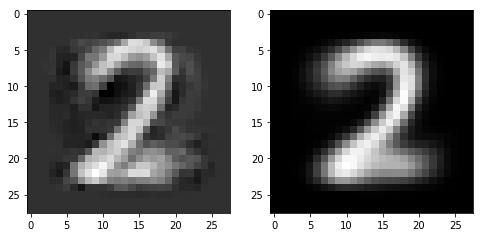

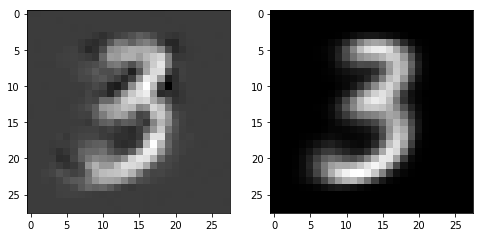

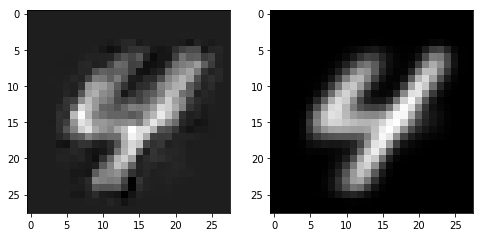

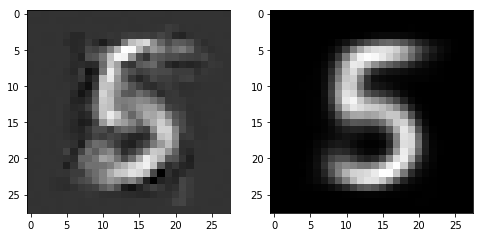

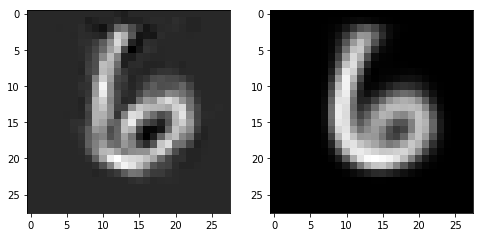

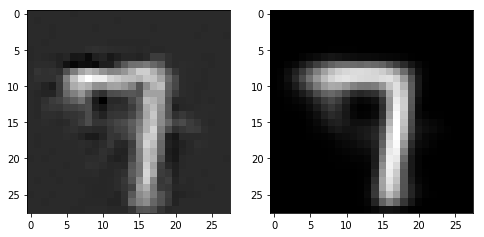

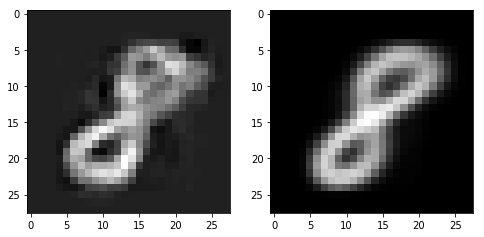

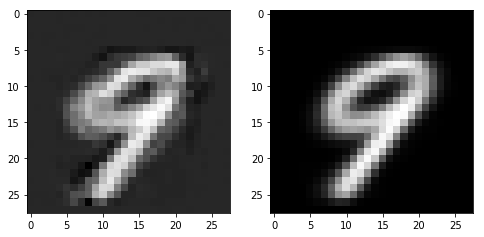

In [21]:
# this block is a lot slower than the previous block.
# but results are much better than the previous.
from sklearn.mixture import BayesianGaussianMixture as bgm

class gmm_gen:
    def __init__(self):
        self.distributions = []
        
    def fit(self,x,y,num):
        self.n_cats = len(set(y))
        self.distributions = []
        for cat in range(self.n_cats):
            xK = x[y == cat]
            gmm = bgm(num)
            gmm.fit(xK)
            self.distributions.append(gmm)
    
    def sample_give_y(self,cat):
        dist = self.distributions[cat]
        sample, cluster = dist.sample()
        meanOfCluster = dist.means_[cluster]
        return sample.reshape(28,28), meanOfCluster.reshape(28,28)

num_styles = 10
X, Y = util.get_mnist()
gen = gmm_gen()
gen.fit(X,Y,num_styles)
n_samples = 10
for k in range(n_samples):
    sample_generated, cluster_mean = gen.sample_give_y(k)
    plt.figure(figsize=(8,16))
    plt.subplot(121)
    plt.imshow(sample_generated,cmap='gray')
    plt.subplot(122)
    plt.imshow(cluster_mean,cmap='gray')
    plt.show()

# Autoencoders
* One of the simplest unsupervised learning
* auto = self
* NN that predicts (construct) its own input
* `fit(X,X)`instead of `fit(X,Y)`
* Hidden Layers to capture important informations/features
* Forces NN to learn compact/efficient representation of the input if num elements in hidden layer are smaller than input size
* Or encodes the data into another format

In [1]:
import tensorflow as tf
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import util
import numpy as np

X, Y = util.get_mnist()

Reading in and transforming data...


epoch: 0 batch: 0 cost: 0.23184768855571747
epoch: 0 batch: 100 cost: 0.23016473650932312
epoch: 1 batch: 0 cost: 0.07657001167535782
epoch: 1 batch: 100 cost: 0.037822917103767395
epoch: 2 batch: 0 cost: 0.031441204249858856
epoch: 2 batch: 100 cost: 0.02108239196240902
epoch: 3 batch: 0 cost: 0.02378496155142784
epoch: 3 batch: 100 cost: 0.018203070387244225
epoch: 4 batch: 0 cost: 0.017340051010251045
epoch: 4 batch: 100 cost: 0.014629916287958622
epoch: 5 batch: 0 cost: 0.015586987137794495
epoch: 5 batch: 100 cost: 0.013313827104866505
epoch: 6 batch: 0 cost: 0.014520090073347092
epoch: 6 batch: 100 cost: 0.01332758367061615
epoch: 7 batch: 0 cost: 0.0153776491060853
epoch: 7 batch: 100 cost: 0.01266736164689064
epoch: 8 batch: 0 cost: 0.014642655849456787
epoch: 8 batch: 100 cost: 0.011872168630361557
epoch: 9 batch: 0 cost: 0.013141174800693989
epoch: 9 batch: 100 cost: 0.013074422255158424
epoch: 10 batch: 0 cost: 0.012645592913031578
epoch: 10 batch: 100 cost: 0.01152767613530

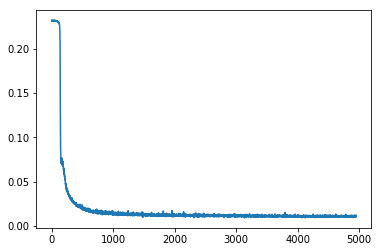

In [18]:
class Autoencoder:
    def __init__(self,input_size, hidden_size):
        tf.reset_default_graph()
        self.x  = tf.placeholder(dtype=tf.float32,shape = (None, input_size))
        init_mean = 0.0
        init_std = 0.001
        self.hidden = tf.layers.dense(self.x,
                                      hidden_size,
                                      activation=tf.nn.relu,
                                      kernel_initializer=tf.random_normal_initializer(mean=init_mean,
                                                                                      stddev=init_std),
                                      name = "hiddenLayer")
        self.output = tf.layers.dense(self.hidden,
                                      input_size,
                                      activation=tf.nn.sigmoid,
                                      kernel_initializer=tf.random_normal_initializer(mean=init_mean,
                                                                                      stddev=init_std),
                                      name = "outputLayer")
        self.cost = tf.losses.mean_squared_error(self.x,self.output)
        self.train = tf.train.RMSPropOptimizer(learning_rate=0.005).minimize(self.cost)
        self.init_op = tf.global_variables_initializer()
        self.sess = tf.InteractiveSession()
        self.sess.run(self.init_op)
    
    def fit(self, X, epochs=30, batch_sz=64):
        costs = []
        for epoch in range(epochs):
            X = shuffle(X)
            training_size = X.shape[0]
            batch_id = 0
            for batch_start in range(0,training_size, batch_sz):
                batch_end = min(batch_start+batch_sz, training_size-1)
                x_batch = X[batch_start:batch_end,:]
                _,c = self.sess.run([self.train,self.cost],
                                    feed_dict = {self.x:x_batch})
                costs.append(c)
                if (batch_id % 100 == 0):
                    print("epoch: {} batch: {} cost: {}".format(epoch,batch_id,c))
                batch_id +=1
        plt.plot(costs)
        plt.show()
        
    def predict(self,x_in):
        return self.sess.run([self.output,self.hidden],feed_dict = {self.x:x_in})

hidden_side = 6
model = Autoencoder(28*28, hidden_side*hidden_side)
model.fit(X,epochs=30,batch_sz=256)

(28, 28)


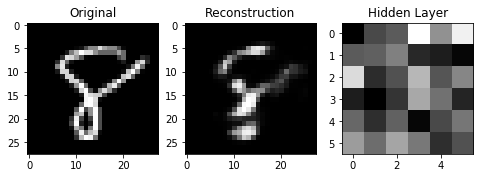

(28, 28)


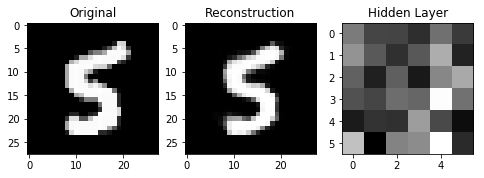

(28, 28)


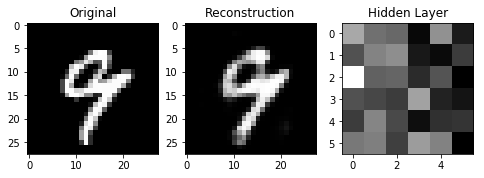

(28, 28)


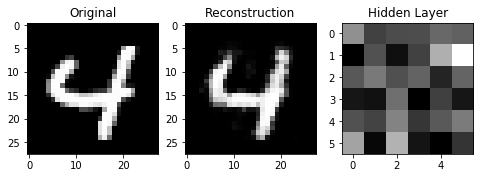

(28, 28)


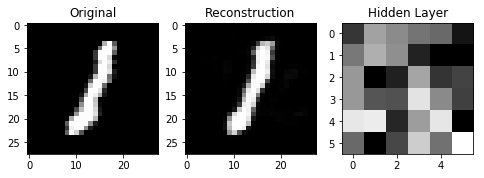

(28, 28)


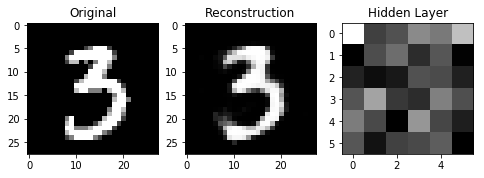

(28, 28)


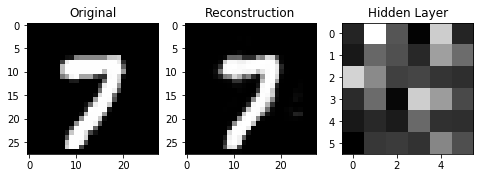

(28, 28)


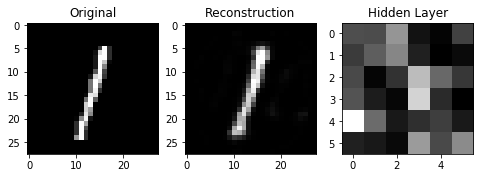

(28, 28)


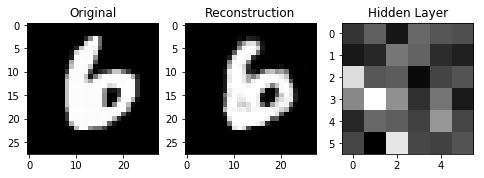

(28, 28)


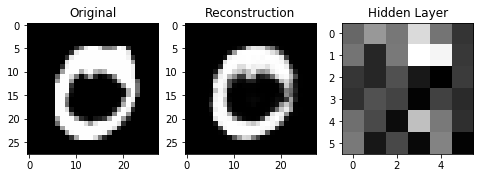

In [19]:
# plot reconstruction
for it in range(10):
    plt.figure(figsize=(8,16))
    i = np.random.choice(len(X))
    x = X[i]
    im,hid = model.predict([x])
    im = np.float32(im.reshape(28, 28))
    print(im.shape)
    hid = np.float32(hid.reshape(hidden_side,hidden_side))
    plt.subplot(131)
    plt.imshow(x.reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.subplot(132)
    plt.imshow(im, cmap='gray')
    plt.title("Reconstruction")
    plt.subplot(133)
    plt.imshow(hid, cmap='gray')
    plt.title("Hidden Layer")
    plt.show()

In [20]:
model.sess.close()

# Variational Autoencoder (VAE):
* NN to reproduce its input
* can map data to latent space
* can generate samples by first sampling from latent space

We have seen Autoencoders above. Lets discuss the term Varitational.
* Refers to variational inference/Bayes
* Realm of Bayesian Machine Learning
* Can be thought as an extension of Expectation-maximization (EM)

Data Flow:
* VAE is built by encode and decoder parts.
* Encoder: generates $q(z)$ which is not a value but a distribution or precisely parameters of a distribution.
* In decoder we draw a sample from $z \sim q(z)$ and feed it to the decoder.
* Output of the decodes $\hat{X}$ is also a distribution
* Sometimmes we pick the output as output rather than probability distribution
* $x_{reconstructed} \sim \hat{X}$ we need to generate samples from this distribution
* $p(x_{reconstructed}=1|x)$ in case output is Bernoulli

More Details about Encoder:
* The decoder can output some means and stds.
* std should be positive
    * We can use softplus activation function $softplus(a)=log(1+exp(a))$


* Encoder output distribution is a function of the input $x$  whic is $q(z|x)$
* Encoder is trying to approximate $p(z|x)$.
* $p(z|x)$ can be thought as true conditional distribution of $z|x$, and $q(z|x)$ as our NN approximation of it

# Cost Function:
* Objective Function to increase: ELBO (Evidence Lower Bound):
$$ELBO = E[log\ p(x|z)] - D_{KL}[q(z|x) || p(z)]$$
* Cost is $-ELBO$
* $E[log\ p(x|z)]$ is negative cross-entropy between original data and reconstructed data
* KL-Divergence:
    * KL Divergence between $q(z|x)$ and $p(z)$
    * In Bayesian ML we call $p(z)$ the "prior" and we can choose it.
    * For convenience, we choose $p(z)=N(0,1)$
    * KL divergance allows us to compare two probability distributions
    $$ D_{KL}[q(x) || p(x)] = \int q(x)\ log \frac{q(x)}{p(x)} dx $$
    * if $p=q$, $KDL = 0$
    * if $q!=p$, $KDL >  0$
    * This encourages $q(z|x)$ to be like $p(z)=N(0,1)$
* First Part $E[log\ p(x|z)]$ how close is the output to the target.
* Second part is a regulizer


# The Reparameterization Trick
* We cannot do backward propagation through a function that has sampling
* Encoder outputs mean and std $\mu(x;\theta), \sigma(x;\theta)$
* which represetns $q(z|x)=N(\mu(x;\theta),\sigma(x;\theta)), z \sim q(z|x)$
* $z = \mu(x;\theta) + \sigma(x;\theta) \epsilon, \epsilon \sim N(0,1)$
* Now $\epsilon$ is stochastic and it does not depends on $\theta$
$$ \frac{\partial J}{\partial \theta} = \frac{\partial J}{ \partial z} \frac{\partial z}{\partial \theta} = \frac{\partial J}{\partial z} \Big[\frac{\partial \mu}{\partial \theta} + \epsilon \frac{\partial \sigma}{\partial \theta}\Big]$$

In [1]:
# tesnorflow of VAE
import tensorflow as tf
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import util
import numpy as np

X, Y = util.get_mnist()


Normal = tf.contrib.distributions.Normal
Bernoulli = tf.contrib.distributions.Bernoulli
logFolder = "../../TFlog"
X = (X > 0.5).astype(np.float32)

Reading in and transforming data...


In [2]:
class VAE:
    def __init__(self, in_size,hidden_layer_sizes,latent_space_size):
        tf.reset_default_graph()
        self.X = tf.placeholder(dtype=tf.float32,shape=(None, in_size))
        init_mean = 0
        init_std = 0.001
        
        num_hidden_layers = len(hidden_layer_sizes)
        self.encoders = []
        self.decoders = []
        
        # encoder Part
        with tf.variable_scope("encoder"):
            input_layer = self.X
            i = 0
            for hidden_size in hidden_layer_sizes:
                i+=1
                input_layer = tf.layers.dense(input_layer,hidden_size,
                                              activation=tf.nn.relu,
                                              kernel_initializer=tf.random_normal_initializer(mean=init_mean,
                                                                                              stddev=init_std),
                                              name = "encoder_" + str(i))
                self.encoders.append(input_layer)
        
        # last layer of encoder: output mean with no activation and std with softmax activation
        self.latent_space_mean = tf.layers.dense(input_layer,
                                                 latent_space_size,
                                                 kernel_initializer=
                                                 tf.random_normal_initializer(mean=init_mean,
                                                                              stddev=init_std),
                                                 name = "latent_mean")
        self.latent_space_std = tf.layers.dense(input_layer,latent_space_size,
                                                activation=tf.nn.softplus,
                                                kernel_initializer=
                                                tf.random_normal_initializer(mean=init_mean,
                                                                             stddev=init_std),
                                                name = "latent_std")

        self.encoders.append(self.latent_space_mean)
        self.encoders.append(self.latent_space_std)
        
        standard_normal = Normal(loc=np.zeros(latent_space_size, dtype=np.float32),
                                 scale=np.ones(latent_space_size, dtype=np.float32))
        
        
        e = standard_normal.sample(tf.shape(self.latent_space_mean)[0])
        self.Z = self.latent_space_mean + self.latent_space_std * e
        
        decoder_in = self.Z
        
        with tf.variable_scope("decoder"):
            print("----------decoder-----------")
            i = num_hidden_layers
            for hidden_size in reversed(hidden_layer_sizes):
                print("decoder", i , hidden_size)
                decoder_in = tf.layers.dense(decoder_in,hidden_size,
                                             activation=tf.nn.relu,
                                             kernel_initializer=tf.random_normal_initializer(mean=init_mean,
                                                                                             stddev=init_std),
                                             name = "decoder_"+str(i))
                i-=1
                self.decoders.append(decoder_in)
            logits =tf.layers.dense(decoder_in,in_size,
                                    kernel_initializer=tf.random_normal_initializer(mean=init_mean,
                                                                                    stddev=init_std),
                                    name="decoder_last")
        posterior_predictive_logits = logits # save for later
        self.X_hat_distribution = Bernoulli(logits=logits)
        
        # take samples from X_hat
        # we will call this the posterior predictive sample
        self.posterior_predictive = self.X_hat_distribution.sample()
        self.posterior_predictive_probs = tf.nn.sigmoid(logits)
        
        # Prior Distribution Sampling
        # take sample from a Z ~ N(0, 1)
        # and put it through the decoder
        # we will call this the prior predictive sample
        
        standard_normal = Normal(
            loc=np.zeros(latent_space_size, dtype=np.float32),
            scale=np.ones(latent_space_size, dtype=np.float32))
        
        Z_std = standard_normal.sample(1)
        current_layer_value = Z_std
        # pass the sample through the decoder
        with tf.variable_scope("decoder",reuse=True):
            print("----------decoder reuse-----------")
            i = num_hidden_layers
            for hidden_size in reversed(hidden_layer_sizes):
                print("decoder", i , hidden_size)
                current_layer_value = tf.layers.dense(current_layer_value,
                                                      hidden_size,
                                                      activation=tf.nn.relu,
                                                      kernel_initializer=
                                                      tf.random_normal_initializer(mean=init_mean,
                                                                                   stddev=init_std),
                                                      name="decoder_"+str(i))
                i-=1
            logits = tf.layers.dense(current_layer_value,
                                     in_size,
                                     name="decoder_last")
        # Bernouli(logits)
        prior_predictive_dist = Bernoulli(logits)
        self.prior_predictive = prior_predictive_dist.sample()
        #probability of each pixel (not relative to each other)
        self.prior_predictive_probs = tf.nn.sigmoid(logits) 
        
        # prior predictive from input
        self.Z_input = tf.placeholder(tf.float32, shape=(None, latent_space_size))
        current_layer_value = self.Z_input
        with tf.variable_scope("decoder",reuse=True):
            i = num_hidden_layers
            for hidden_size in reversed(hidden_layer_sizes):
                current_layer_value = tf.layers.dense(current_layer_value,
                                                      hidden_size,
                                                      activation=tf.nn.relu,
                                                      kernel_initializer=
                                                      tf.random_normal_initializer(mean=init_mean,
                                                                                   stddev=init_std),
                                                      name="decoder_"+str(i),
                                                      reuse=True)
                i-=1
            logits = tf.layers.dense(current_layer_value,
                                     in_size,
                                     name="decoder_last",
                                     reuse=True)
        self.prior_predictive_from_input_probs = tf.nn.sigmoid(logits)
        
        # optimizer and loss function
        kl = -tf.log(self.latent_space_std) + 0.5 * (self.latent_space_std**2  + self.latent_space_mean**2)-0.5
        kl = tf.reduce_sum(kl, axis=1)
        expected_log_likelihood = tf.reduce_sum(
            self.X_hat_distribution.log_prob(self.X),1)
        self.elbo = tf.reduce_sum(expected_log_likelihood - kl)
        self.train_op = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(-self.elbo)
        
        writer = tf.summary.FileWriter(logFolder, tf.get_default_graph())
        
        self.init_op = tf.global_variables_initializer()
        self.sess = tf.InteractiveSession()
        self.sess.run(self.init_op)
        
    def fit(self,X,epochs = 30, batch_sz=64):
        costs = []
        c = 0
        n_batches = len(X) // batch_sz
        print("n_batches:", n_batches)
        for i in range(epochs):
            np.random.shuffle(X)
            for j in range(n_batches):
                batch = X[j*batch_sz:(j+1)*batch_sz]
                _, c, = self.sess.run((self.train_op, self.elbo), feed_dict={self.X: batch})
                c /= batch_sz # just debugging
                costs.append(c)
            print("Epoch: %d, cost: %.3f" % (i, c),end="\r")
        plt.plot(costs)
        plt.show()
    
    def transform(self, X):
        return self.sess.run(self.latent_space_mean,feed_dict={self.X: X}) 
    
    def prior_predictive_with_input(self, Z):
        return self.sess.run(self.prior_predictive_from_input_probs,feed_dict={self.Z_input: Z})
    
    def posterior_predictive_sample(self, X):
        # returns a sample from p(x_new | X)
        return self.sess.run(self.posterior_predictive, feed_dict={self.X: X})
    
    def prior_predictive_sample_with_probs(self):
        # returns a sample from p(x_new | z), z ~ N(0, 1)
        return self.sess.run((self.prior_predictive, self.prior_predictive_probs))
    
vae = VAE(784, [200, 150],100)

----------decoder-----------
decoder 2 150
decoder 1 200
----------decoder reuse-----------
decoder 2 150
decoder 1 200


n_batches: 164


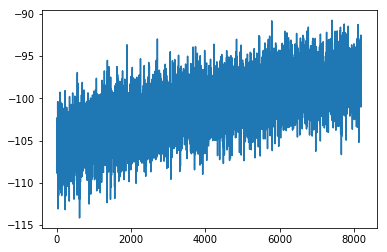

In [4]:
vae.fit(X,batch_sz=256,epochs=50)

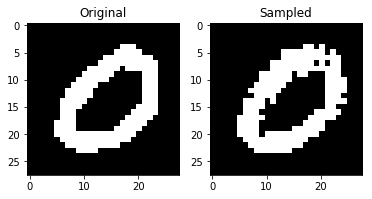

Generate another?


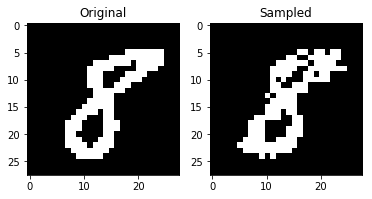

Generate another?


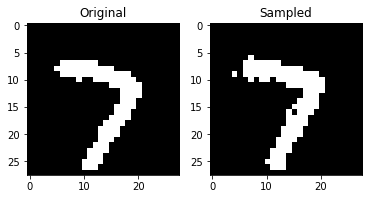

Generate another?


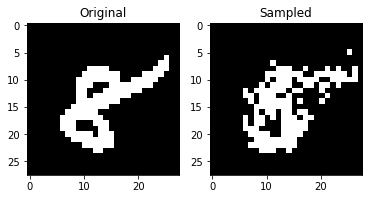

Generate another?


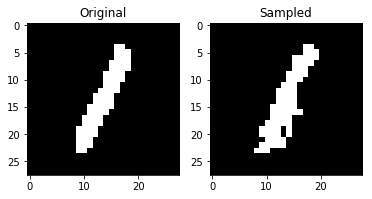

Generate another?


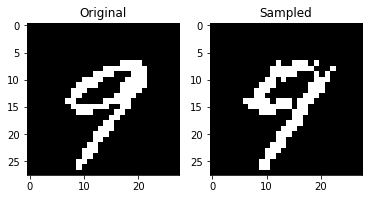

Generate another?


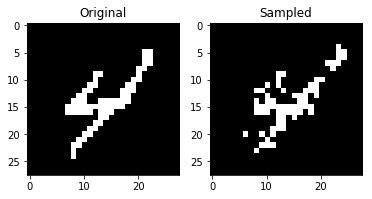

Generate another?n


In [5]:
# plot reconstruction
done = False
while not done:
    i = np.random.choice(len(X))
    x = X[i]
    im = vae.posterior_predictive_sample([x]).reshape(28, 28)
    plt.subplot(1,2,1)
    plt.imshow(x.reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.subplot(1,2,2)
    plt.imshow(im, cmap='gray')
    plt.title("Sampled")
    plt.show()

    ans = input("Generate another?")
    if ans and ans[0] in ('n' or 'N'):
        done = True

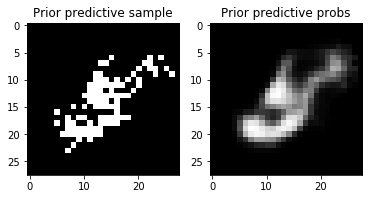

Generate another?


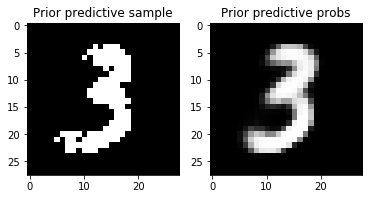

Generate another?


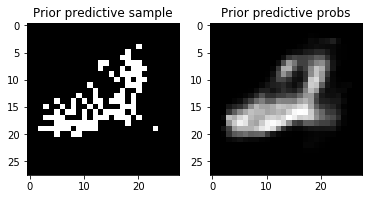

Generate another?


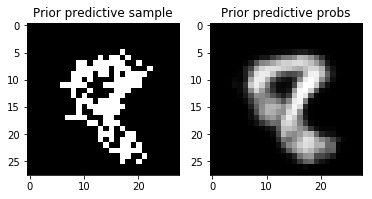

Generate another?


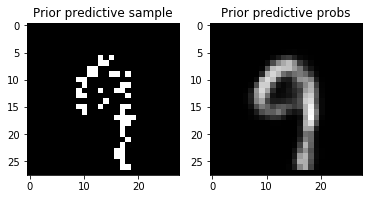

Generate another?


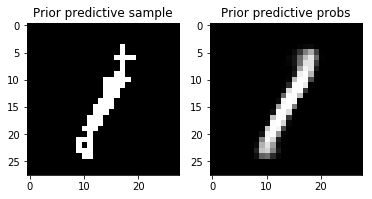

Generate another?


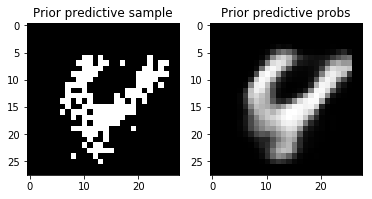

Generate another?


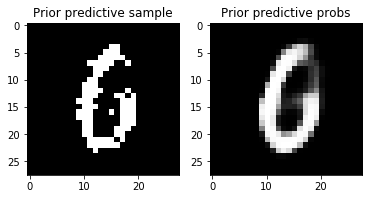

Generate another?


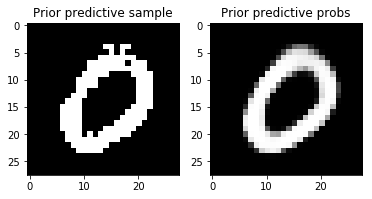

Generate another?


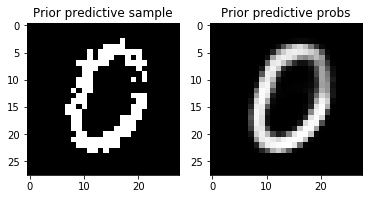

Generate another?n


In [6]:
# plot output from random samples in latent space
done = False
while not done:
    im, probs = vae.prior_predictive_sample_with_probs()
    im = im.reshape(28, 28)
    probs = probs.reshape(28, 28)
    plt.subplot(1,2,1)
    plt.imshow(im, cmap='gray')
    plt.title("Prior predictive sample")
    plt.subplot(1,2,2)
    plt.imshow(probs, cmap='gray')
    plt.title("Prior predictive probs")
    plt.show()

    ans = input("Generate another?")
    if ans and ans[0] in ('n' or 'N'):
        done = True
        

In [7]:
vae.sess.close()